In [25]:
import torch
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [8]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
data_folder = "/home/fv/storage1/qml/cifar_data"

In [16]:
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


FULL_dataset = datasets.CIFAR10(root=data_folder, train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root=data_folder, train=False, download=True, transform=transforms_cifar)

100%|██████████| 170498071/170498071 [00:51<00:00, 3296106.77it/s] 


Extracting /home/fv/storage1/qml/cifar_data/cifar-10-python.tar.gz to /home/fv/storage1/qml/cifar_data
Files already downloaded and verified


In [17]:
train01_idx = np.where(np.array(FULL_dataset.targets) == 0 | (np.array(FULL_dataset.targets) == 1))[0]
test01_idx = np.where(np.array(test_dataset.targets) == 0 | (np.array(test_dataset.targets) == 1))[0]

In [18]:
FULL_dataset.data =FULL_dataset.data[train01_idx]
FULL_dataset.targets = np.array(FULL_dataset.targets)[train01_idx].tolist()
test_dataset.data = test_dataset.data[test01_idx]
test_dataset.targets = np.array(test_dataset.targets)[test01_idx].tolist()


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

new_train_dataset = CustomDataset(FULL_dataset.data, FULL_dataset.targets, transform=transforms_cifar) 
new_test_dataset = CustomDataset(test_dataset.data, test_dataset.targets, transform=transforms_cifar)

In [19]:
torch.manual_seed(46)
val_size = 0.3*len(new_train_dataset)
train_size = len(new_train_dataset) - val_size

In [20]:
train_set, val_set = torch.utils.data.random_split(new_train_dataset, [int(train_size), int(val_size)])
len(train_set), len(val_set)

(7000, 3000)

In [21]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

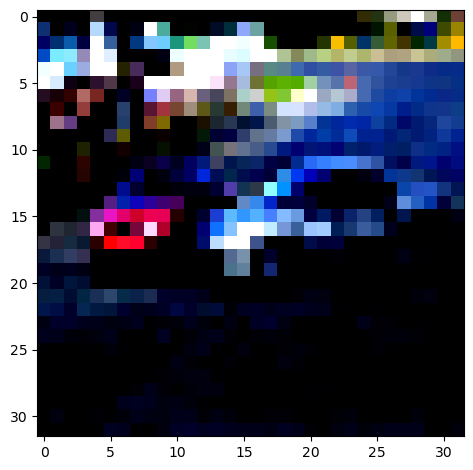

In [22]:
val_batch = next(iter(val_loader))

val_input, val_target = val_batch
single_image_val_batch = val_batch[0]
image_np = single_image_val_batch.numpy()
image_np = np.clip(image_np, 0, 1)
plt.imshow(np.transpose(image_np[0], (1, 2, 0)))
plt.tight_layout()

In [68]:
### Create my VGG

class MyVGG(nn.Module):
    def __init__(self) -> None:
        super(MyVGG, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 2))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [39]:
gpu_device = torch.device("cuda")

In [69]:
def evaluate(model: torch.nn.Module, loader: torch.utils.data.DataLoader,
             criterion: callable, device: torch.device) -> tuple[float, float]:
    """
    Evaluate both loss and accuracy on a specific set, in this case it shoule be the
    validation set. The loss and accuracy are computed with torch.no_grad(), i.e.
    in the evaluation mode, without computing the gradient at each epoch.
    :param model: (torch.nn.Module) model to evaluate;
    :param loader: (torch.utils.data.DataLoader) data loader;
    :param criterion: (callable) loss function;
    :param device: (torch.device) device to use;
    :return: (tuple) loss and accuracy of the model after evaluation.
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total_instances = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            classifications = torch.argmax(outputs, dim=1)
            correct += (classifications == labels).sum().item()
            total_instances += len(inputs)

    average_loss = total_loss / len(loader)
    accuracy = (correct / total_instances) * 100
    return average_loss, accuracy


def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader,
          val_loader: torch.utils.data.DataLoader, epochs: int, learning_rate: float,
          seed: int, device: torch.device) -> None:
    """
    Function which trains the model on training dataloader and evaluates it
    on the validation dataloader. During training, the model is set to train mode,
    it computes loss and accuracy after each epoch either on training and validation sets.
    :param model: (torch.nn.Module) the model to be trained and validated;
    :param train_loader: (torch.utils.data.DataLoader) training data loader;
    :param val_loader: (torch.utils.data.DataLoader) validation data loader;
    :param epochs: (int) number of epochs to train the model;
    :param learning_rate: (float) learning rate;
    :param seed: (int) random seed for reproducibility;
    :param device: (torch.device) device to use the model with - it can be cpu or gpu (cuda);
    :return: None.
    """
    torch.manual_seed(seed)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0 # la loss che calcoliamo è una loss che si aggiorna dopo ogni epoca, non è dopo ogni batch.
        total_correct = 0
        total_instances = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            with torch.no_grad():
                classifications = torch.argmax(outputs, dim=1)
                correct_predictions = (classifications == labels).sum().item()
                total_correct += correct_predictions
                total_instances += len(inputs)

        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        print(
            f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, "
            f"Validation Loss: {val_loss}, "
            f"Accuracy: {(total_correct / total_instances) * 100:.2f}%, "
            f"Validation Accuracy: {val_accuracy:.2f}%"
        )


def test(model: torch.nn.Module, test_loader: torch.utils.data.DataLoader, device: torch.device) -> tuple:
    """
    Evaluate the model on the test dataloader.
    :param model: (callable) the model to evaluate;
    :param test_loader: (torch.utils.data.DataLoader) the test dataloader;
    :param device: (torch.device) the device to use for evaluation;
    :return: accuracy: (float) the accuracy on the test dataloader;
    """
    model.eval() # model settato in evaluation (non ho bisogno di calcolare il gradiente)
    correct = 0
    total = 0
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return (accuracy, np.array(all_predictions))

In [70]:
vgg_net = MyVGG()
print("Train my VGG model...")

train(model=vgg_net,
      train_loader=train_loader,
      val_loader=val_loader,
      epochs=10,
      device=gpu_device,
      learning_rate=0.001,
      seed=8888)

Train my VGG model...


 10%|█         | 1/10 [00:03<00:27,  3.07s/it]

Epoch 1, Loss: 0.9159335342320529, Validation Loss: 0.6226648638645808, Accuracy: 56.30%, Validation Accuracy: 70.77%


 20%|██        | 2/10 [00:06<00:24,  3.11s/it]

Epoch 2, Loss: 0.6253296895460649, Validation Loss: 0.6662541603048643, Accuracy: 64.03%, Validation Accuracy: 61.60%


 30%|███       | 3/10 [00:09<00:21,  3.12s/it]

Epoch 3, Loss: 0.3600525612180883, Validation Loss: 0.2300737046947082, Accuracy: 85.56%, Validation Accuracy: 91.63%


 40%|████      | 4/10 [00:12<00:19,  3.24s/it]

Epoch 4, Loss: 0.23690697848796843, Validation Loss: 0.2870692952225606, Accuracy: 90.51%, Validation Accuracy: 86.73%


 50%|█████     | 5/10 [00:16<00:16,  3.26s/it]

Epoch 5, Loss: 0.18616697056726975, Validation Loss: 0.2255447879433632, Accuracy: 92.69%, Validation Accuracy: 90.67%


 60%|██████    | 6/10 [00:19<00:12,  3.24s/it]

Epoch 6, Loss: 0.14763793850486928, Validation Loss: 0.14163517082730928, Accuracy: 94.37%, Validation Accuracy: 94.37%


 70%|███████   | 7/10 [00:22<00:09,  3.21s/it]

Epoch 7, Loss: 0.11857604790817608, Validation Loss: 0.205102545209229, Accuracy: 95.67%, Validation Accuracy: 93.87%


 80%|████████  | 8/10 [00:25<00:06,  3.19s/it]

Epoch 8, Loss: 0.10442866689779541, Validation Loss: 0.12632047571241856, Accuracy: 96.16%, Validation Accuracy: 95.27%


 90%|█████████ | 9/10 [00:28<00:03,  3.19s/it]

Epoch 9, Loss: 0.07859620282595808, Validation Loss: 0.09573141035313408, Accuracy: 97.01%, Validation Accuracy: 96.23%


100%|██████████| 10/10 [00:31<00:00,  3.19s/it]

Epoch 10, Loss: 0.06317483027550307, Validation Loss: 0.11395557954286535, Accuracy: 97.60%, Validation Accuracy: 95.67%


In [71]:
test_acc, predictions = test(model=vgg_net, test_loader=test_loader, device=gpu_device)

Test Accuracy: 96.45%


In [72]:
pred = predictions
predictions

array([0, 1, 1, ..., 0, 0, 1])

In [63]:
len(predictions)

2000

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

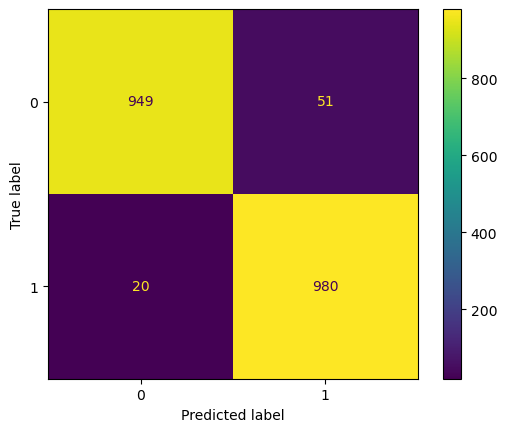

In [73]:
ConfusionMatrixDisplay(confusion_matrix(y_pred=predictions, y_true=test_loader.dataset.targets)
).plot()